# Improving the Random Forest Model Part 1



## Three Approaches to Making a Better ML Model

1. More high-quality data
2. Hyperparameter tuning of algorithm
3. Try different algorithm

We will look at approach 1. here with the other two methods to be explored later!

# Recap of Previous Work

We are working on a supervised, regression machine learning task where the goal is to predict the maximum temperature tomorrow (in Seattle, WA) from past historical data. The first attempt used one year of data for training. 

The code below recreates the simple random forest model written up in [my article](https://medium.com/@williamkoehrsen/random-forest-in-python-24d0893d51c0) on Medium. We use the default parameters except for increasing the number of decision trees (n_estimators) to 1000. The original model achieves a mean average error of 3.83 degrees and an accuracy of 94%.

In [2]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as pandas dataframe and display first 5 rows
original_features = pd.read_csv('data/temps.csv')
original_features = pd.get_dummies(original_features)

# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
original_labels = np.array(original_features['actual'])

# Remove the labels from the features
# axis 1 refers to the columns
original_features= original_features.drop('actual', axis = 1)

# Saving feature names for later use
original_feature_list = list(original_features.columns)

# Convert to numpy array
original_features = np.array(original_features)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
original_train_features, original_test_features, original_train_labels, original_test_labels = train_test_split(original_features, original_labels, test_size = 0.25, random_state = 42)

# The baseline predictions are the historical averages
baseline_preds = original_test_features[:, original_feature_list.index('average')]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - original_test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'degrees.')

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(original_train_features, original_train_labels);

# Use the forest's predict method on the test data
predictions = rf.predict(original_test_features)

# Calculate the absolute errors
errors = abs(predictions - original_test_labels)

# Print out the mean absolute error (mae)
print('Average model error:', round(np.mean(errors), 2), 'degrees.')

# Compare to baseline
improvement_baseline = 100 * abs(np.mean(errors) - np.mean(baseline_errors)) / np.mean(baseline_errors)
print('Improvement over baseline:', round(improvement_baseline, 2), '%.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / original_test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average baseline error:  5.06 degrees.
Average model error: 3.83 degrees.
Improvement over baseline: 24.24 %.
Accuracy: 93.99 %.


# Collect More Data

All data is obtained from the [NOAA climate data online](https://www.ncdc.noaa.gov/cdo-web/) tool. Feel free to check for your city! 

This time we will use 6 years of historical data and include some additional variables to augment the temperature features used in the simple model. 

In [4]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as a dataframe
features = pd.read_csv('data/temps_extended.csv')
features.head(5)

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
0,2011,1,1,Sat,4.92,0.00,0,36,37,45.6,40,40
1,2011,1,2,Sun,5.37,0.00,0,37,40,45.7,39,50
2,2011,1,3,Mon,6.26,0.00,0,40,39,45.8,42,42
3,2011,1,4,Tues,5.59,0.00,0,39,42,45.9,38,59
4,2011,1,5,Wed,3.80,0.03,0,42,38,46.0,45,39


In [5]:
print('We have {} days of data with {} variables.'.format(*features.shape))

We have 2191 days of data with 12 variables.


## Numerical and Visual Inspection of Data

In [6]:
round(features.describe(), 2)

,year,month,day,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
count,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00
mean,2013.50,6.52,15.71,7.37,0.12,0.01,61.17,61.18,60.29,61.18,60.31
std,1.71,3.45,8.80,3.15,0.25,0.15,13.09,13.08,10.73,13.08,15.87
min,2011.00,1.00,1.00,0.89,0.00,0.00,29.00,29.00,45.10,29.00,25.00
25%,2012.00,4.00,8.00,5.14,0.00,0.00,51.00,51.00,50.10,51.00,49.00
50%,2014.00,7.00,16.00,6.71,0.00,0.00,60.00,60.00,58.80,60.00,60.00
75%,2015.00,10.00,23.00,9.17,0.12,0.00,71.00,71.00,70.20,71.00,71.00
max,2017.00,12.00,31.00,21.25,2.20,3.00,96.00,96.00,77.40,96.00,97.00


In [7]:
# Use datetime for dealing with dates
import datetime

# Get years, months, and days
years = features['year']
months = features['month']
days = features['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

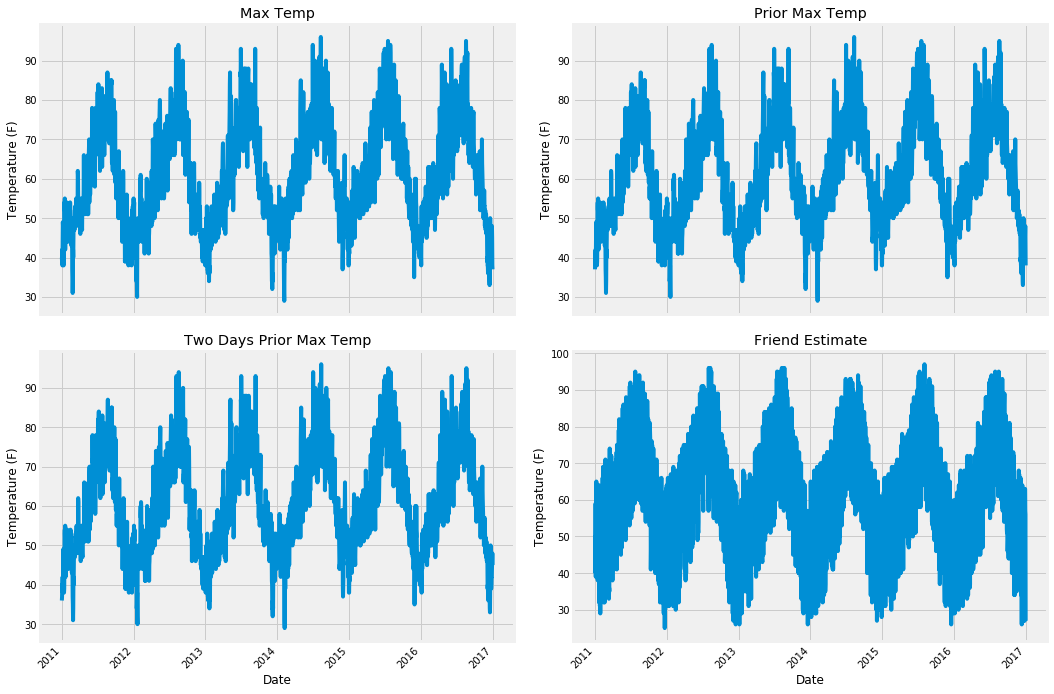

In [8]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature (F)'); ax2.set_title('Prior Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature (F)'); ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature (F)'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

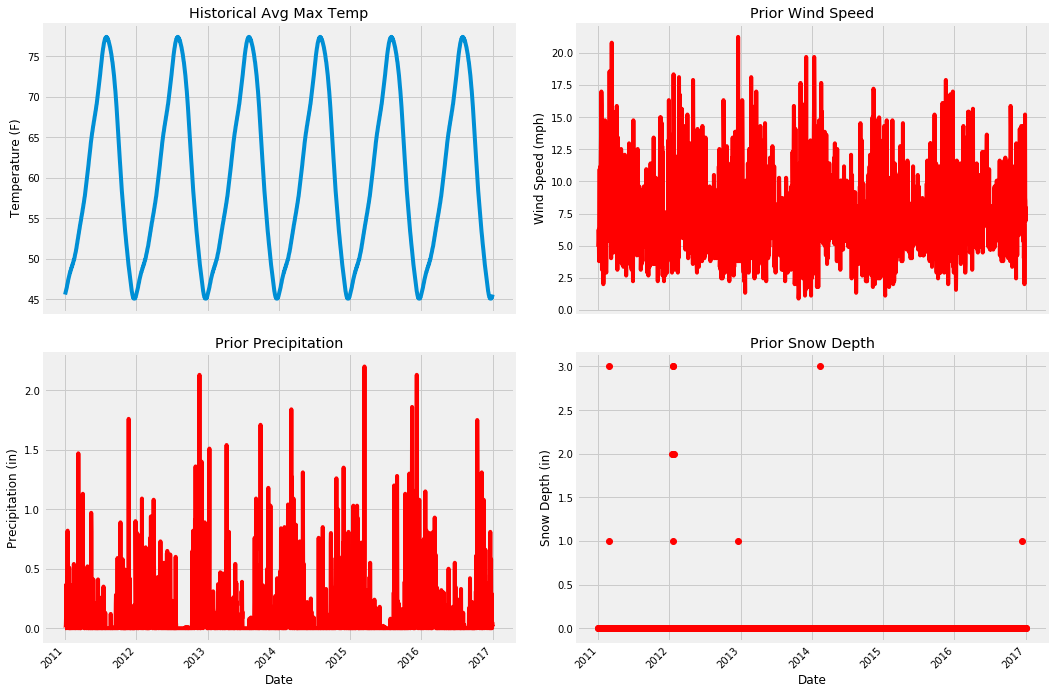

In [9]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)

# Historical Average Max Temp
ax1.plot(dates, features['average'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); ax1.set_title('Historical Avg Max Temp')

# Prior Avg Wind Speed 
ax2.plot(dates, features['ws_1'], 'r-')
ax2.set_xlabel(''); ax2.set_ylabel('Wind Speed (mph)'); ax2.set_title('Prior Wind Speed')

# Prior Precipitation
ax3.plot(dates, features['prcp_1'], 'r-')
ax3.set_xlabel('Date'); ax3.set_ylabel('Precipitation (in)'); ax3.set_title('Prior Precipitation')

# Prior Snowdepth
ax4.plot(dates, features['snwd_1'], 'ro')
ax4.set_xlabel('Date'); ax4.set_ylabel('Snow Depth (in)'); ax4.set_title('Prior Snow Depth')

plt.tight_layout(pad=2)

## Pairplots

One of my favorite graphs to make is a pairplot which shows all the relationships between variables in a dataset. We can do this with the seaborn library and examine the plots to see which variables are highly correlated. We would suspect those that are more correlated with max temperature would be more useful for prediction.

In [10]:
# Create columns of seasons for pair plotting colors
seasons = []

for month in features['month']:
    if month in [1, 2, 12]:
        seasons.append('winter')
    elif month in [3, 4, 5]:
        seasons.append('spring')
    elif month in [6, 7, 8]:
        seasons.append('summer')
    elif month in [9, 10, 11]:
        seasons.append('fall')

# Will only use six variables for plotting pairs
reduced_features = features[['temp_1', 'prcp_1', 'average', 'actual']]
reduced_features['season'] = seasons

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


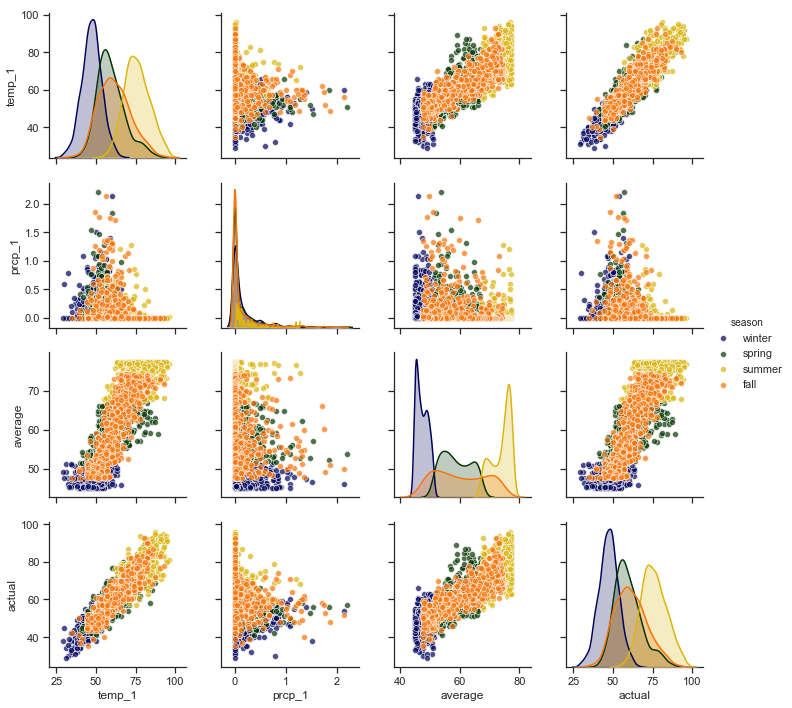

In [11]:
# Use seaborn for pair plots
import seaborn as sns
sns.set(style="ticks", color_codes=True);

# Create a custom color palete
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])

# Make the pair plot with a some aesthetic changes
sns.pairplot(reduced_features, hue = 'season', diag_kind = 'kde', palette= palette, plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(shade=True)); 

## Data Preparation

In [12]:
# One Hot Encoding
features = pd.get_dummies(features)

# Extract features and labels
labels = features['actual']
features = features.drop('actual', axis = 1)

# List of features for later use
feature_list = list(features.columns)

# Convert to numpy arrays
import numpy as np

features = np.array(features)
labels = np.array(labels)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 42)

In [13]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1643, 17)
Training Labels Shape: (1643,)
Testing Features Shape: (548, 17)
Testing Labels Shape: (548,)


## Establish New Baseline

The new baseline will be the predictions of the model trained on only one year of data but tested on the expanded testing set. In order to make predictions, we will need to restrict the features to those in the original one year of data (exclude the wind speed, precipitation, and snow depth). Testing with the same test set allows us to assess the effect of using additional training data. 

In [14]:
# Find the original feature indices 
original_feature_indices = [feature_list.index(feature) for feature in
                                      feature_list if feature not in
                                      ['ws_1', 'prcp_1', 'snwd_1']]

# Create a test set of the original features
original_test_features = test_features[:, original_feature_indices]

# Make predictions on test data using the model trained on original data
baseline_predictions = rf.predict(original_test_features)

# Performance metrics
baseline_errors = abs(baseline_predictions - test_labels)

print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(baseline_errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
baseline_mape = 100 * np.mean((baseline_errors / test_labels))

# Calculate and display accuracy
baseline_accuracy = 100 - baseline_mape
print('Accuracy:', round(baseline_accuracy, 2), '%.')

Metrics for Random Forest Trained on Original Data
Average absolute error: 4.3 degrees.
Accuracy: 92.49 %.


## Train on Expanded Data and Features

The rf_exp uses the same number of decision trees (n_estimators) but is trained on the longer dataset with 3 additional features.

In [15]:
# Instantiate random forest and train on new features
from sklearn.ensemble import RandomForestRegressor

rf_exp = RandomForestRegressor(n_estimators= 1000, random_state=42)
rf_exp.fit(train_features, train_labels);

## Metrics for Expanded Data and Features

In [16]:
# Make predictions on test data
predictions = rf_exp.predict(test_features)

# Performance metrics
errors = abs(predictions - test_labels)

print('Metrics for Random Forest Trained on Expanded Data')
print('Average absolute error:', round(np.mean(errors), 4), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / test_labels))

# Compare to baseline
improvement_baseline = 100 * abs(mape - baseline_mape) / baseline_mape
print('Improvement over baseline:', round(improvement_baseline, 2), '%.')

# Calculate and display accuracy
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for Random Forest Trained on Expanded Data
Average absolute error: 3.7038 degrees.
Improvement over baseline: 16.66 %.
Accuracy: 93.74 %.


Using more data (more data points and more features) has decreased the absolute error, increased performance relative to the baseline, and increased accuracy.
Although the exact metrics will depend on the random state used, overall, we can be confident using additional high-quality data improves our model.

At this point, our model can predict the maximum temperature for tomrrow with an average error of __3.7__ degrees resulting in an accuracy of __93.7%__.

# Feature Reduction

From previous experience and the graphs produced at the beginning, we know that some features are not useful for our temperature prediction problem. To reduce the number of features, which will reduce runtime, hopefully without significantly reducing performance, we can examine the feature importances from the random forest.

### Feature Importances

In [17]:
# Get numerical feature importances
importances = list(rf_exp.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.83
Variable: average              Importance: 0.06
Variable: ws_1                 Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: friend               Importance: 0.02
Variable: year                 Importance: 0.01
Variable: month                Importance: 0.01
Variable: day                  Importance: 0.01
Variable: prcp_1               Importance: 0.01
Variable: snwd_1               Importance: 0.0
Variable: weekday_Fri          Importance: 0.0
Variable: weekday_Mon          Importance: 0.0
Variable: weekday_Sat          Importance: 0.0
Variable: weekday_Sun          Importance: 0.0
Variable: weekday_Thurs        Importance: 0.0
Variable: weekday_Tues         Importance: 0.0
Variable: weekday_Wed          Importance: 0.0


#### Visualize Feature Importances

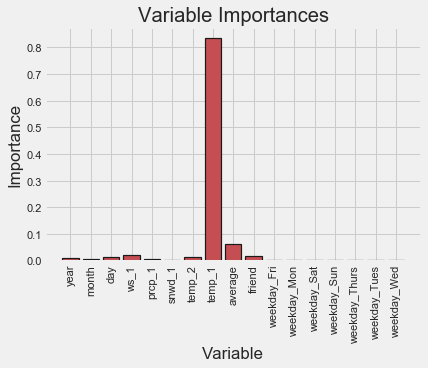

In [18]:
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

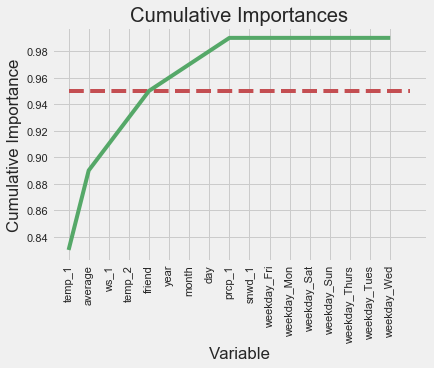

In [19]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

### Limit Number of Features 

We will now reduce the number of features in use by the model to only those required to account for 95% of the importance. 
The same number of features must be used in the training and testing sets.

In [20]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 6


In [21]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:6]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = train_features[:, important_indices]
important_test_features = test_features[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)


Important train features shape: (1643, 6)
Important test features shape: (548, 6)


### Training on Important Features

In [22]:
# Train the expanded model on only the important features
rf_exp.fit(important_train_features, train_labels);

### Evaluate on Important features

In [23]:
# Make predictions on test data
predictions = rf_exp.predict(important_test_features)

# Performance metrics
errors = abs(predictions - test_labels)

print('Average absolute error:', round(np.mean(errors), 4), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 3.8212 degrees.
Accuracy: 93.56 %.


Using only the eight most important features (instead of all 16) results in a minor decrease in accuracy by 0.17 degrees. For some models, decreasing the number of features can increase performance and therefore should be done. However, in other situations, performance will decrease but run time will also decrease. The final decision on how many features to retain will therefore be a trade-off between accuracy and run time. 

## Compare Trade-Offs

In [24]:
# Use time library for run time evaluation
import time

# All features training and testing time
all_features_time = []

# Do 10 iterations and take average for all features
for _ in range(10):
    start_time = time.time()
    rf_exp.fit(train_features, train_labels)
    all_features_predictions = rf_exp.predict(test_features)
    end_time = time.time()
    all_features_time.append(end_time - start_time)

all_features_time = np.mean(all_features_time)
print('All features total training and testing time:', round(all_features_time, 2), 'seconds.')

All features total training and testing time: 6.01 seconds.


In [25]:
# Time training and testing for reduced feature set
reduced_features_time = []

# Do 10 iterations and take average
for _ in range(10):
    start_time = time.time()
    rf_exp.fit(important_train_features, train_labels)
    reduced_features_predictions = rf_exp.predict(important_test_features)
    end_time = time.time()
    reduced_features_time.append(end_time - start_time)

reduced_features_time = np.mean(reduced_features_time)
print('Reduced features total training and testing time:', round(reduced_features_time, 2), 'seconds.')

Reduced features total training and testing time: 4.19 seconds.


### Accuracy vs Run-Time

In [26]:
all_accuracy =  100 * (1- np.mean(abs(all_features_predictions - test_labels) / test_labels))
reduced_accuracy = 100 * (1- np.mean(abs(reduced_features_predictions - test_labels) / test_labels))

comparison = pd.DataFrame({'features': ['all (17)', 'reduced (5)'], 
                           'run_time': [round(all_features_time, 2), round(reduced_features_time, 2)],
                           'accuracy': [round(all_accuracy, 2), round(reduced_accuracy, 2)]})

comparison[['features', 'accuracy', 'run_time']]

,features,accuracy,run_time
0,all (17),93.74,6.01
1,reduced (5),93.56,4.19


In [27]:
relative_accuracy_decrease = 100 * (all_accuracy - reduced_accuracy) / all_accuracy
print('Relative decrease in accuracy:', round(relative_accuracy_decrease, 3), '%.')

relative_runtime_decrease = 100 * (all_features_time - reduced_features_time) / all_features_time
print('Relative decrease in run time:', round(relative_runtime_decrease, 3), '%.')

Relative decrease in accuracy: 0.198 %.
Relative decrease in run time: 30.2 %.


# Concluding Graphs

In [28]:
# Find the original feature indices 
original_feature_indices = [feature_list.index(feature) for feature in
                                      feature_list if feature not in
                                      ['ws_1', 'prcp_1', 'snwd_1']]

# Create a test set of the original features
original_test_features = test_features[:, original_feature_indices]

# Time to train on original data set (1 year)
original_features_time = []

# Do 10 iterations and take average for all features
for _ in range(10):
    start_time = time.time()
    rf.fit(original_train_features, original_train_labels)
    original_features_predictions = rf.predict(original_test_features)
    end_time = time.time()
    original_features_time.append(end_time - start_time)
    
original_features_time = np.mean(original_features_time)

In [29]:
# Calculate mean absolute error for each model
original_mae = np.mean(abs(original_features_predictions - test_labels))
exp_all_mae = np.mean(abs(all_features_predictions - test_labels))
exp_reduced_mae = np.mean(abs(reduced_features_predictions - test_labels))

# Calculate accuracy for model trained on 1 year of data
original_accuracy = 100 * (1 - np.mean(abs(original_features_predictions - test_labels) / test_labels))

# Create a dataframe for comparison
model_comparison = pd.DataFrame({'model': ['original', 'exp_all', 'exp_reduced'], 
                                 'error (degrees)':  [original_mae, exp_all_mae, exp_reduced_mae],
                                 'accuracy': [original_accuracy, all_accuracy, reduced_accuracy],
                                 'run_time (s)': [original_features_time, all_features_time, reduced_features_time]})

# Order the dataframe
model_comparison = model_comparison[['model', 'error (degrees)', 'accuracy', 'run_time (s)']]

### Comparison of Three Models

There are three models to compare: the model trained on a single year of data and the original number of features, the model trained on six years of data with the full set of features, and the model trained on six years of data with only the 6 most important features

In [30]:
model_comparison

,model,error (degrees),accuracy,run_time (s)
0,original,4.297223,92.493041,1.246265
1,exp_all,3.703781,93.743398,6.007556
2,exp_reduced,3.821197,93.557849,4.193296


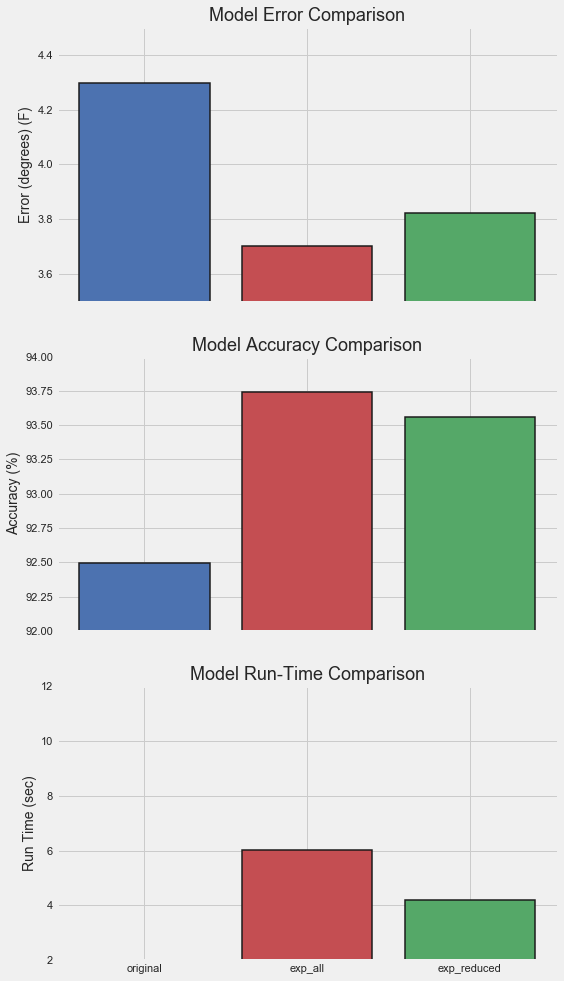

In [31]:
# Make plots 
# Set up the plotting layout
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (8,16), sharex = True)

# Set up x-axis
x_values = [0, 1, 2]
labels = list(model_comparison['model'])
plt.xticks(x_values, labels)

# Set up fonts
fontdict = {'fontsize': 18}
fontdict_yaxis = {'fontsize': 14}

# Error Comparison
ax1.bar(x_values, model_comparison['error (degrees)'], color = ['b', 'r', 'g'], edgecolor = 'k', linewidth = 1.5)
ax1.set_ylim(bottom = 3.5, top = 4.5)
ax1.set_ylabel('Error (degrees) (F)', fontdict = fontdict_yaxis); 
ax1.set_title('Model Error Comparison', fontdict= fontdict)

# Accuracy Comparison
ax2.bar(x_values, model_comparison['accuracy'], color = ['b', 'r', 'g'], edgecolor = 'k', linewidth = 1.5)
ax2.set_ylim(bottom = 92, top = 94)
ax2.set_ylabel('Accuracy (%)', fontdict = fontdict_yaxis); 
ax2.set_title('Model Accuracy Comparison', fontdict= fontdict)

# Run Time Comparison
ax3.bar(x_values, model_comparison['run_time (s)'], color = ['b', 'r', 'g'], edgecolor = 'k', linewidth = 1.5)
ax3.set_ylim(bottom = 2, top = 12)
ax3.set_ylabel('Run Time (sec)', fontdict = fontdict_yaxis); 
ax3.set_title('Model Run-Time Comparison', fontdict= fontdict);
